# CDC NDI Mortality - Syft Duet - Data Scientist 🥁

This worksheet is intended to illustrate functionality of a shared statistical platform, using a partially synthetic public-use dataset that mirrors the restricted-use dataset. Ultimately, these processes would apply to the restricted-use data.

Sample data compiled from the public-use linked mortality files share at https://www.cdc.gov/nchs/data-linkage/mortality.htm provided by the National Center for Health Statistics (NCHS).

## PART 1: Connect to a Remote Duet Server

As the Data Scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server in their Notebook.

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. The code will look like this, importantly with their real Server ID.

```
import syft as sy
duet = sy.duet('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
```

This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Paste the code or Server ID that the Data Owner gives you and run it in the cell below. It will return your Client ID which you must send to the Data Owner to enter into Duet so it can pair your notebooks.

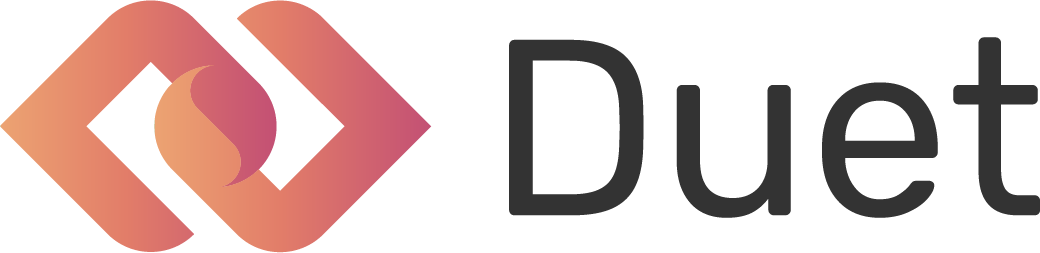

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [1]:
import syft as sy

duet = sy.join_duet(loopback=True)

In [2]:
sy.load("pandas")
sy.load("statsmodels")

In [3]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: d1664aa2067b4c8ba24ea0a9cc03afd1>,[df],,<class 'pandas.core.frame.DataFrame'>


In [4]:
df_ptr = duet.store["df"]

In [5]:
# df_ptr.get(request_block=True, delete_obj=False) # for testing

In [6]:
cancer_ptr = df_ptr[(df_ptr["UCOD_LEADING"] == 2) & (df_ptr["ELIGSTAT"] == 1)]

In [7]:
heart_ptr = df_ptr[(df_ptr["UCOD_LEADING"] == 1) & (df_ptr["ELIGSTAT"] == 1)]

In [8]:
# Compute simple means and for the cancer and heart subgroups that had diabetes
# listed as a multiple cause of death
cancer_mean_ptr = cancer_ptr["DIABETES"].mean()

In [9]:
# Compute simple means and standard deviations for the cancer and heart subgroups
# that had diabetes as a multiple cause of death
heart_mean_ptr = heart_ptr["DIABETES"].mean()

In [10]:
cancer_mean = cancer_mean_ptr.get(request_block=True, delete_obj=False)
cancer_mean

0.0

In [11]:
heart_mean = heart_mean_ptr.get(request_block=True, delete_obj=False)
heart_mean

0.3333333432674408

In [12]:
# Sample means data should account for weights. Write a custom function that uses the weights.


def weighted_mean(dx, key, weight_key="WGT_NEW"):
    w = dx[weight_key]
    v = dx[key]
    return (w * v).sum() / w.sum()


cancer_wm_ptr = weighted_mean(cancer_ptr, "DIABETES")
heart_wm_ptr = weighted_mean(heart_ptr, "DIABETES")

In [13]:
# Example of a small subgroup (sample size = 6)
# Cancer-deaths from males aged 47 who died in 2015
# We should check for small cell sizes here
# subgroup = cancer_ptr[(cancer_ptr["SEX"]==1) & (cancer_ptr["AGE_P"]==47) & (cancer_ptr["DODYEAR"]==2015)]
subgroup = cancer_ptr[
    (cancer_ptr["SEX"] == 1)
    & (cancer_ptr["AGE_P"] == 51)
    & (cancer_ptr["DODYEAR"] == 2013)
]
print(subgroup["DIABETES"].mean().get(request_block=True, delete_obj=False))
print(weighted_mean(subgroup, "DIABETES").get(request_block=True, delete_obj=False))
print(len(subgroup))

# These stats are problematic, as the subgroup is too small to report (n=6)
subgroup.get(request_block=True, delete_obj=False)

nan
None
0


,data_year,ID_PERSON,SEX,AGE_P,STRATUM,PSU,ELIGSTAT,MORTSTAT,UCOD_LEADING,DIABETES,HYPERTEN,DODQTR,DODYEAR,WGT_NEW,SA_WGT_NEW


In [14]:
# TODO: Add statsmodels
# import statsmodels.api as sm
# from statsmodels.genmod.generalized_linear_model import GLM
# from statsmodels.genmod.families import Binomial

# Drop any missing values in the dataset (those under 18)
df = df_ptr.dropna(subset=["MORTSTAT"])
# Keep only the eligible portion
df = df[df["ELIGSTAT"] == 1]

# Ignore people > 80
df = df[df["AGE_P"] <= 80]

# A person is alive if MORTSTAT==0
df["is_alive"] = df["MORTSTAT"] == 0

# Assign a helpful column for sex (0==male, 1==female)
df["sex"] = "male"
#df.loc[df["SEX"] == 2, "sex"] = "female"

#x_ptr = df["AGE_P"]
# _x = sm.add_constant(x)
#_y_ptr = df["is_alive"]

# results = GLM(_y, _x, family=Binomial()).fit()
# print(results.summary())

In [25]:
duet.statsmodels.api.add_constant

In [26]:
x_ptr = df["AGE_P"]
_x_ptr = duet.statsmodels.api.add_constant(x_ptr)
_y_ptr = df["is_alive"]

# results = GLM(_y, _x, family=Binomial()).fit()
# print(results.summary())

In [30]:
from statsmodels.genmod.families import Binomial

model =  duet.statsmodels.genmod.generalized_linear_model.GLM(_y_ptr, _x_ptr, family=Binomial())
result = model.fit()

In [31]:
"""
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial

_x = df["AGE_P"].get(request_block=True, delete_obj=False)
# _x = sm.add_constant(x)
_y = df["is_alive"].get(request_block=True, delete_obj=False)

results = GLM(_y, _x, family=Binomial()).fit()
"""

'\nimport statsmodels.api as sm\nfrom statsmodels.genmod.generalized_linear_model import GLM\nfrom statsmodels.genmod.families import Binomial\n\n_x = df["AGE_P"].get(request_block=True, delete_obj=False)\n# _x = sm.add_constant(x)\n_y = df["is_alive"].get(request_block=True, delete_obj=False)\n\nresults = GLM(_y, _x, family=Binomial()).fit()\n'

In [32]:
import io
import pandas as pd
remote_summary = result.get(request_block=True, delete_obj=False)
pd.read_csv(io.StringIO(remote_summary), names=[1, 2, 3, 4, 5, 6, 7]) 

,1,2,3,4,5,6,7
0,Generalized Linear Model Regression ...,NaN,NaN,NaN,NaN,NaN,NaN
1,Dep. Variable:,is_alive,No. Observations:,93,NaN,NaN,NaN
2,Model:,GLM,Df Residuals:,91,NaN,NaN,NaN
3,Model Family:,Binomial,Df Model:,1,NaN,NaN,NaN
4,Link Function:,logit,Scale:,1.0000,NaN,NaN,NaN
5,Method:,IRLS,Log-Likelihood:,-40.907,NaN,NaN,NaN
6,Date:,Fri,02 Apr 2021,Deviance:,81.815,NaN,NaN
7,Time:,23:37:14,Pearson chi2:,81.7,NaN,NaN,NaN
8,No. Iterations:,5,,,NaN,NaN,NaN
9,Covariance Type:,nonrobust,,,NaN,NaN,NaN


In [21]:
df.get(request_block=True, delete_obj=False)  # for testing

,data_year,ID_PERSON,SEX,AGE_P,STRATUM,PSU,ELIGSTAT,MORTSTAT,UCOD_LEADING,DIABETES,HYPERTEN,DODQTR,DODYEAR,WGT_NEW,SA_WGT_NEW,is_alive,sex
0,1997,19970003080101,2,33,142,2,1,0.0,NaN,NaN,NaN,NaN,NaN,2134.0,4618.0,True,male
1,1997,19970003090102,2,52,95,2,1,0.0,NaN,NaN,NaN,NaN,NaN,1288.0,2972.0,True,male
2,1997,19970003100101,1,41,95,2,1,0.0,NaN,NaN,NaN,NaN,NaN,1509.0,3977.0,True,male
3,1997,19970003110101,1,67,95,2,1,0.0,NaN,NaN,NaN,NaN,NaN,1717.0,2604.0,True,male
4,1997,19970003130101,1,25,95,2,1,0.0,NaN,NaN,NaN,NaN,NaN,1506.0,4112.0,True,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1997,19970004080103,1,27,23,2,1,0.0,NaN,NaN,NaN,NaN,NaN,3021.0,10119.0,True,male
96,1997,19970004090102,2,73,23,2,1,1.0,1.0,0.0,0.0,1.0,2009.0,2216.0,4658.0,False,male
97,1997,19970004100101,1,48,55,1,1,1.0,10.0,1.0,0.0,1.0,2015.0,1953.0,1979.0,False,male
98,1997,19970004110101,1,56,55,2,1,1.0,7.0,1.0,0.0,1.0,2015.0,2927.0,5916.0,False,male


In [22]:
x_ptr.get(request_block=True, delete_obj=False)

0     33
1     52
2     41
3     67
4     25
      ..
95    27
96    73
97    48
98    56
99    73
Length: 93, dtype: int64

In [23]:
_y_ptr.get(request_block=True, delete_obj=False)

0      True
1      True
2      True
3      True
4      True
      ...  
95     True
96    False
97    False
98    False
99     True
Length: 93, dtype: bool